# POD-NN method

## The advection-diffusion problem

Let us  considere the following BVP. It is based on the 2D stationary advection-diffusion. It is here parametrized by the diffusivity coefficient $\lambda(\mu)$. The equations read: 

$$\begin{equation}
\begin{cases}
-div(\lambda(\mu)\nabla u)+w\nabla u=f & in~~\Omega\\
~~~~~~\hfill~~~~~~~~~~~~~~~~~~u=g & in~~\varGamma_{in}\\
~~~\hfill~~~~-\lambda(\mu)\nabla u.n=0 & in~~\varGamma_{wall}\\
~~~\hfill~~~~-\lambda(\mu)\nabla u.n=0 & in~~\varGamma_{out}
\end{cases}
\label{eq:Advection-non-affine}
\end{equation}$$

with $\lambda(\mu)=\exp(\mu_{0}(\mu + 1))$. The scalar $\mu_{0}=0.7$ and $\mu\in\textbf{P}=[\mu_{min},{~}\mu_{max}],{~}  \mu_{min}=1,{~} \mu_{max}=10$.

### Modules  import and initializations

In [1]:
### Modules importation
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku
from tensorflow.keras import callbacks
import scipy as sc
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import sys,os
import random 
#import pandas as pd
import sklearn.utils
# Verbosity
fit_verbosity = 1

2024-12-12 09:06:15.860824: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 09:06:15.892621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-12 09:06:16.422838: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Normalization and non-affine functions 

In [2]:
# The scaling function for data normalisation
# Scaling function
def scaling(S, S_max, S_min):
    S[ : ] = (S - S_min)/(S_max - S_min)
    
# Inverse scaling function
def inverse_scaling(S, S_max, S_min):
    S[ : ] = (S_max - S_min) * S + S_min
    
# The non-affinity function
def Lambda(mu):
    return np.exp(mu0*(mu+1.))

## The offline phase

### Preparing the data

The RB POD matrix $Brb=[\xi_{1},\dots,\xi_{M}]\in\mathbb{R}^{NN\times N_{rb}}$. The RB matrix is constructed by POD method. It is computed for 10000 snapshots of Problem (1). The reduced matrix here is of size $N_{rb}=5$. $$\$$
For the training step of the NN, the snapshots matrix $S=[U_{h}(\mu_{1}),\dots,U_{h}(\mu_{M})]\in\mathbb{R}^{NN\times M}$ has already been computed with $M=10000$.

#### Load the data from numpy files

In [3]:
# Prepare the data
# Load the data from the numpy file
# Snaphots matrix
S =  np.load('Snapshots_non_affine.npy') # of size M*NN
S = S.transpose() # of size NN*M

# The reduced POD basis
Brb = np.load('Brb.npy') # of size NN*Nrb#
Brb = Brb.real
Nrb = len(Brb.transpose())

# The parameter matrix
P = np.load('parameter_non_affine.npy') # of size M x 1
P = P.reshape(len(P),1)

#### Computation of the reduced outputs for the NN and randomly shuffle the data

The reduced outputs are computed by the formula: $$\begin{equation}Urb = Brb^{T}U_{h}(\mu)\in\mathbb{R}^{N_{rb}}\end{equation}$$ with $\mu\in\textbf{P}=[\mu_{min},{~}\mu_{max}]$. $\\$
We denote by $Urb_{POD}=Brb^{T}S$.

In [4]:
# Computation of the reduced solutions: Brb^T*Uh(mu)
Urb_POD = np.dot(Brb.transpose(),S) # of size Nrb*M
#print("Urb_POD size=",Urb_POD.shape)

# Transpose 
Urb_POD = Urb_POD.transpose() # of size M*Nrb
print("Urb_POD size=",Urb_POD.shape)

# Randomy shufl the data set
shuffle = np.arange(len(Urb_POD))
np.random.shuffle(shuffle)
Urb_POD = Urb_POD[shuffle]
P = P[shuffle]
print("Urb_POD before normalization",Urb_POD)
print("P before normalization",P)

Urb_POD size= (10000, 5)
Urb_POD before normalization [[-3.91171195e+01 -7.44696817e-01 -3.33082341e-01  1.02522034e-01
   1.79626258e-02]
 [-4.09309878e+01  7.40101680e-01 -7.28900135e-01 -2.05954026e-02
  -2.49620907e-02]
 [-3.68939827e+01 -1.54966041e+00  3.08306254e-01 -2.25030350e-02
  -7.36426857e-04]
 ...
 [-3.64569752e+01 -1.68039591e+00  4.32098080e-01 -5.54359342e-02
  -8.88229681e-03]
 [-4.04827680e+01  2.81886590e+00  7.77179204e-01  7.64805653e-02
   1.03941968e-02]
 [-4.05802297e+01  1.70858981e-01 -7.25122216e-01  7.20586163e-02
  -8.32810059e-03]]
P before normalization [[108.18994029]
 [ 28.95655432]
 [511.31901933]
 ...
 [998.99590053]
 [  5.69867689]
 [ 45.09317358]]


#### Data normalization

The normalization of the data is done as follows: $$\\$$
The input parameters for the NN are such that: $$\begin{equation}\tilde{\mu_{i}} = \frac{\mu_{i}}{\mu_{max}}\end{equation}$$ for $1\leq i\leq M$ $$\$$
The outputs (RB solutions) for the NN are normalized as follows:$$\begin{equation}(\tilde{Urb}_{POD})_{ij} = \frac{(Urb_{POD})_{ij}-\underset{i,j}{\min}(Urb_{POD})_{ij}}{\underset{i,j}{\max}(Urb_{POD})_{ij}-\underset{i,j}{\min}(Urb_{POD})_{ij}}\end{equation}$$ for $1\leq i\leq M$ and $1\leq j\leq N_{rb}$ $$\\$$

In [5]:
# Data normalization
# Normalization of the parameter set
# Obtain the min and the max of P
P_max = np.max(P); P_min = np.min(P)
# Normalize the parameter vector P
P = P/P_max

# Normalization of the reduced matrix
# Obtain the min and the max of the reduced outputs BrbUh
Urb_POD_max = np.max(Urb_POD); Urb_POD_min = np.min(Urb_POD)
scaling(Urb_POD, Urb_POD_max, Urb_POD_min)

print("P after normalization",P)
print("Urb_POD after normalization",Urb_POD)

P after normalization [[0.04899135]
 [0.01311231]
 [0.23153915]
 ...
 [0.4523725 ]
 [0.00258052]
 [0.02041941]]
Urb_POD after normalization [[0.04219791 0.91211302 0.92144445 0.93131974 0.92940276]
 [0.00107693 0.94577388 0.91247114 0.92852863 0.92842964]
 [0.09259713 0.89386424 0.93598494 0.92848539 0.92897884]
 ...
 [0.10250423 0.89090042 0.93879134 0.92773879 0.92879417]
 [0.01123822 0.99290013 0.94661444 0.93072938 0.92923118]
 [0.00902873 0.93286896 0.91255678 0.93062913 0.92880674]]


#### Load the already trained NN

In [6]:
# Load the pre-trained NN stored in h5 format
Model = km.load_model(f'Neural-network.h5')

# Summary of the model: layers and number of parameters 
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                34        
                                                                 
 dense_1 (Dense)             (None, 17)                306       
                                                                 
 dense_2 (Dense)             (None, 17)                306       
                                                                 
 dense_3 (Dense)             (None, 17)                306       
                                                                 
 dense_4 (Dense)             (None, 17)                306       
                                                                 
 dense_5 (Dense)             (None, 17)                306       
                                                                 
 dense_6 (Dense)             (None, 17)                3

2024-12-12 09:06:17.756318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 09:06:17.782660: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## The online phase

### New parameter value

In [7]:
# The onlinbe phase 
# Predict the new solution U_POD_NN
# The constant mu_0
mu0 = 0.7

# New value of the physical parameter mu
print('New value for mu ')
# The parameter input for the NN
mu = np.array([[float(input())]])
print("mu=",mu)

# The non-affine parameter
diffus = Lambda(mu)
print("diffus=",diffus)

# Normalization of the non-affine parameter
diffus = diffus/P_max
print("diffus after normalization=",diffus)

New value for mu 


 1


mu= [[1.]]
diffus= [[4.05519997]]
diffus after normalization= [[0.0018363]]


### Compute the RB solution for the new parameter value by performing the NN

In [21]:
# Predict the reduced basis solution of the new parameter
basis = Model.predict([np.array([diffus])])
# Rescaling the predicted reduced basis solution
inverse_scaling(basis, Urb_POD_max, Urb_POD_min)
# The change of variable from the RB basis to complete FE one.
Uh_POD_NN = Brb@basis.T

1/1 [==============================] - 0s 15ms/step


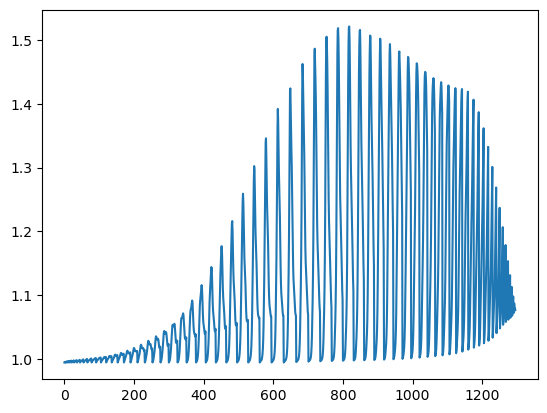

In [20]:
plt.plot(range(len(FE_basis)), FE_basis)

### Save the POD-NN solution in numpy file

In [22]:
np.save('Uh_POD_NN',Uh_POD_NN)